In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import os
import matplotlib.pyplot as plt

import rpy2
# from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [ ]:
info = pd.read_csv('/Scientific Research/info.csv')
info
micepath = '/Scientific Research//'
micefiles = os.listdir('/Scientific Research')

AllFC = pd.DataFrame()

In [ ]:
age10 = []
age20 = []
age21 = []

up_gene10 = []
down_gene10 = []
up_gene20 = []
down_gene20 = []

CDRAll = set()
gene_num = []
patients = []

dif_gene = pd.DataFrame()
dif_gene['Num'] = range(1, 17)
dif_gene['Region'] = 'Region' + dif_gene['Num'].astype(str)

# Record the number of differential genes in each region (excluding duplicated genes in the three-phase comparisons)
dif_gene['dif_gene_num'] = np.nan

# Record the number of differential genes in the three-phase comparisons
dif_gene['age1VSage0'] = np.nan
dif_gene['age2VSage0'] = np.nan
dif_gene['age2VSage1'] = np.nan

# Record the number of upregulated and downregulated genes in each region
dif_gene['up_gene10'] = np.nan
dif_gene['down_gene10'] = np.nan
dif_gene['up_gene20'] = np.nan
dif_gene['down_gene20'] = np.nan


In [ ]:
ageframe = pd.read_csv(micepath+micefiles[0])
ageframe.dropna(inplace=True)
conmon_gene = ageframe['num'].to_list()
len(conmon_gene)


In [ ]:
for i in range(len(micefiles)):
    data = pd.read_csv(micepath+micefiles[i])
    data.dropna(inplace=True)
    num = data['num'].to_list()

    conmon_gene = [i for i in conmon_gene if i in num]
len(conmon_gene)

# pd.DataFrame(conmon_gene,columns=['genename']).to_csv('conmon_gene_18431.csv',index=False)

In [ ]:
for i in range(len(micefiles)):
    data = pd.read_csv(micepath + micefiles[i])
    data = data[data['num'].isin(conmon_gene)]

    gene_list = data.columns[1:]
    patients = patients + gene_list.to_list()  # Count the occurrence of patients

    # Match CDR values in 'info' with 'donor_id' and 'class' in 'fenzu'
    fenzu = info.copy()
    fenzu['donor_id'] = fenzu['donor_id'].astype(str).apply(lambda x: "S" + x)
    fenzu = fenzu[fenzu['donor_id'].isin(gene_list)].reset_index(drop=True)
    fenzu['stage'] = fenzu['stage'].apply(lambda x: 'age0' if x == 1 else ('age1' if x == 2 else 'age2'))
    fenzu = fenzu.loc[:, ['donor_id', 'stage']]
    fenzu = fenzu.rename(columns={'donor_id': 'list', 'stage': 'class'})

    # One-hot encode 'fenzu['class']'
    design = pd.get_dummies(fenzu['class']).astype(int)
    design.index = fenzu['list'].tolist()
    data.dropna(inplace=True)

    # Save column names as 'genename'
    gene_names = data['num'].tolist()

    # Remove the first two rows from 'data'; the remaining rows are gene features
    data = data.iloc[:, 1:]
    # Change the row index of 'data' to 'genename'
    data.index = gene_names

    # age1-age0
    # Differential analysis using limma; Data preparation
    limma = importr("limma")
    contrast_matrix = limma.makeContrasts("age1-age0", levels=design)

    # Analysis step 1
    fit = limma.lmFit(data, design)
    # Analysis step 2
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    # Analysis step 3
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))

    # Remove rows containing NaN values
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()

    # Use |logFC| > 0.585 and padj < 0.05 (adjusted P-value)
    foldChange = 0.585
    padj = 0.05
    # Filter out all differential genes
    All_diffSig = diffsig.loc[(diffsig['P.Value'] < padj) & (
        (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

    # Upregulated genes
    diffup = All_diffSig.loc[(All_diffSig['P.Value'] < padj)
                            & (All_diffSig['logFC'] > foldChange)]

    # Downregulated genes
    diffdown = All_diffSig.loc[(All_diffSig['P.Value'] < padj) & (
        All_diffSig['logFC'] < -foldChange)]

    age10.append(len(All_diffSig))
    age1age0 = All_diffSig.index.to_list()

    up_gene10.append(len(diffup))
    down_gene10.append(len(diffdown))

    # age2-age0
    # Differential analysis using limma; Data preparation
    contrast_matrix = limma.makeContrasts("age2-age0", levels=design)

    # Analysis step 1
    fit = limma.lmFit(data, design)
    # Analysis step 2
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    # Analysis step 3
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))

    # Remove rows containing NaN values
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()

    # Use |logFC| > 0.585 and padj < 0.05 (adjusted P-value)
    foldChange = 0.585
    padj = 0.05
    # Filter out all differential genes
    All_diffSig = diffsig.loc[(diffsig['P.Value'] < padj) & (
        (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

    # Upregulated genes
    diffup = All_diffSig.loc[(All_diffSig['P.Value'] < padj)
                            & (All_diffSig['logFC'] > foldChange)]

    # Downregulated genes
    diffdown = All_diffSig.loc[(All_diffSig['P.Value'] < padj) & (
        All_diffSig['logFC'] < -foldChange)]

    age20.append(len(All_diffSig))
    age2age0 = All_diffSig.index.to_list()

    up_gene20.append(len(diffup))
    down_gene20.append(len(diffdown))

    # age2-age1
    # Differential analysis using limma; Data preparation
    contrast_matrix = limma.makeContrasts("age2-age1", levels=design)

    # Analysis step 1
    fit = limma.lmFit(data, design)
    # Analysis step 2
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    # Analysis step 3
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))

    # Remove rows containing NaN values
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()

    # Use |logFC| > 0.585 and padj < 0.05 (adjusted P-value)
    foldChange = 0.585
    padj = 0.05
    # Filter out all differential genes
    All_diffSig = diffsig.loc[(diffsig['P.Value'] < padj) & (
        (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

    # Upregulated genes
    diffup = All_diffSig.loc[(All_diffSig['P.Value'] < padj)
                            & (All_diffSig['logFC'] > foldChange)]

    # Downregulated genes
    diffdown = All_diffSig.loc[(All_diffSig['P.Value'] < padj) & (
        All_diffSig['logFC'] < -foldChange)]

    age21.append(len(All_diffSig))
    age2age1 = All_diffSig.index.to_list()

    # Union of differential genes from all three comparisons
    dif_gene_ = set(age1age0).union(age2age0, age2age1)
    gene_num.append(len(dif_gene_))
    CDRAll = CDRAll | dif_gene_  # 13479

len(CDRAll)  # Find 13479 differential genes


In [ ]:
dif_gene['dif_gene_num'] = gene_num
dif_gene['age1VSage0'] =age10
dif_gene['age2VSage0'] =age20
dif_gene['age2VSage1'] =age21

dif_gene['up_gene10'] = up_gene10
dif_gene['down_gene10'] = down_gene10
dif_gene['up_gene20'] = up_gene20
dif_gene['down_gene20'] = down_gene20
dif_gene

In [ ]:
genenames1 = pd.read_csv("D:\\genename5%.csv")
genenames = genenames1['genename'].to_list()
len(genenames)

In [ ]:
# Create a DataFrame to store the count of upregulated and downregulated genes in different age groups
up_down_gene = pd.DataFrame({'Mid-term Group': [dif_gene['up_gene10'].sum(), dif_gene['down_gene10'].sum()],
              'Late-term Group': [dif_gene['up_gene20'].sum(), dif_gene['down_gene20'].sum()]}, index=['Upregulated Genes', 'Downregulated Genes'])
up_down_gene

# Combine data from 16 brain regions into one dataframe 'ageframe'
ageframe = ageframe[ageframe['num'].isin(common_gene)]
ageframe['region'] = 1

for i in range(1, 16):
    data = pd.read_csv(micepath + micefiles[i])
    data = data[data['num'].isin(common_gene)]
    data['region'] = i + 1

    ageframe = pd.concat([ageframe, data], join='outer', ignore_index=True)

# Sort and reset the index of 'ageframe'
ageframe.sort_values(by=['num', 'region'], inplace=True)
ageframe.reset_index(drop=True, inplace=True)
ageframe


In [ ]:
# Combine data from 16 brain regions into one DataFrame 'ageframe'
ageframe = ageframe[ageframe['num'].isin(common_gene)]
ageframe['region'] = 1

for i in range(1, 16):
    data = pd.read_csv(micepath + micefiles[i])
    data = data[data['num'].isin(common_gene)]
    data['region'] = i + 1

    ageframe = pd.concat([ageframe, data], join='outer', ignore_index=True)

ageframe.sort_values(by=['num', 'region'], inplace=True)
ageframe.reset_index(drop=True, inplace=True)
ageframe


In [ ]:
# Count the occurrence of patient data for each brain region
patients_times = pd.DataFrame(pd.value_counts(patients))
patients_times.reset_index(inplace=True)
patients_times.columns=['patient','times']
patients_times


In [ ]:
# Select patients who have data from at least 3 brain regions
patient3 = patients_times[patients_times['times'] >= 3]['patient'].to_list()
patient3 = sorted(patient3)
len(patient3)


In [ ]:
patient3.insert(0,'num')

In [ ]:
patient3

FC

In [ ]:
age10_FC = pd.DataFrame()
age20_FC = pd.DataFrame()
age21_FC = pd.DataFrame()

for m in range(len(micefiles)):
    data = pd.read_csv(micepath + micefiles[m])
    data = data[data['num'].isin(common_gene)]

    columns_list = data.columns[1:]

    # Map CDR values from 'info' to 'fenzu' class
    fenzu = info.copy()
    fenzu['donor_id'] = fenzu['donor_id'].astype(str).apply(lambda x: "S" + x)
    fenzu = fenzu[fenzu['donor_id'].isin(columns_list)].reset_index(drop=True)
    fenzu['stage'] = fenzu['stage'].apply(lambda x: 'age0' if x == 1 else ('age1' if x == 2 else 'age2'))
    fenzu = fenzu.loc[:, ['donor_id', 'stage']]
    fenzu = fenzu.rename(columns={'donor_id': 'list', 'stage': 'class'})

    # One-hot encode 'class' in 'fenzu'
    design = pd.get_dummies(fenzu['class']).astype(int)
    design.index = fenzu['list'].tolist()

    data.dropna(inplace=True)

    # Save gene names
    gene_names = data['num'].tolist()

    # Remove the first two columns from 'data' (leaving gene features)
    data = data.iloc[:, 1:]
    # Change the row index of 'data' to gene names
    data.index = gene_names

    # age1-age0
    # Prepare data for limma differential analysis
    # Create a contrast matrix using the limma package in R
    limma = importr("limma")
    contrast_matrix = limma.makeContrasts("age1-age0", levels=design)

    # Perform the analysis
    fit = limma.lmFit(data, design)
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))

    # Remove rows with missing values
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()

    diffsig.reset_index(inplace=True)
    diffsig['Region'] = m + 1
    age10_temp = diffsig[diffsig['index'].isin(gene_names)]
    age10_FC = pd.concat([age10_FC, age10_temp], join='outer', ignore_index=True)

    # age2-age0
    # Prepare data for limma differential analysis
    # Create a contrast matrix using the limma package in R
    contrast_matrix = limma.makeContrasts("age2-age0", levels=design)

    # Perform the analysis
    fit = limma.lmFit(data, design)
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))

    # Remove rows with missing values
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()

    diffsig.reset_index(inplace=True)
    diffsig['Region'] = m + 1
    age20_temp = diffsig[diffsig['index'].isin(gene_names)]
    age20_FC = pd.concat([age20_FC, age20_temp], join='outer', ignore_index=True)

    # age2-age1
    # Prepare data for limma differential analysis
    # Create a contrast matrix using the limma package in R
    contrast_matrix = limma.makeContrasts("age2-age1", levels=design)

    # Perform the analysis
    fit = limma.lmFit(data, design)
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))

    # Remove rows with missing values
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()

    diffsig.reset_index(inplace=True)
    diffsig['Region'] = m + 1
    age21_temp = diffsig[diffsig['index'].isin(gene_names)]
    age21_FC = pd.concat([age21_FC, age21_temp], join='outer', ignore_index=True)


In [ ]:
age10_FC.sort_values(by=['logFC'], inplace=True)
age10_FC

In [ ]:
age20_FC.sort_values(by=['logFC'], inplace=True)
age20_FC

In [ ]:
age21_FC.sort_values(by=['logFC'], inplace=True)
age21_FC

In [ ]:
# Sort age10_FC by 'index' and 'Region'
age10_FC.sort_values(by=['index', 'Region'], inplace=True)

# Sort age20_FC by 'index' and 'Region'
age20_FC.sort_values(by=['index', 'Region'], inplace=True)

# Display age20_FC
age20_FC


In [ ]:
age10_FC['index'].to_list() == age20_FC['index'].to_list()

In [ ]:
FC = pd.DataFrame({"age1FC": age10_FC['logFC'].to_list()
                  ,"age2FC": age20_FC['logFC'].to_list()
                })
FC

In [ ]:
positive10  = np.where(FC['age1FC'] > 0)[0].tolist()
positive20  = np.where(FC['age2FC'] > 0)[0].tolist()
age10_FC['index'].to_list() == age20_FC['index'].to_list()

In [ ]:
# Reverse the sign of negative values in the 'FC' column
FC['age1FC'] = -FC['age1FC'][FC['age1FC'] < 0]
FC['age2FC'] = -FC['age2FC'][FC['age2FC'] < 0]

# Create a new DataFrame with the desired columns
new_FC = FC[['genenum', 'age1FC', 'age2FC']]


In [ ]:
# Set values below 0.585 in 'age1FC' to 0
FC.loc[FC['age1FC'] < 0.585, 'age1FC'] = 0

# Add a small positive value to 'age1FC' to prevent all-zero weights
FC['age1FC'] += 0.000001

# Set values below 0.585 in 'age2FC' to 0
FC.loc[FC['age2FC'] < 0.585, 'age2FC'] = 0

# Add a small positive value to 'age2FC' to prevent all-zero weights
FC['age2FC'] += 0.000001


In [ ]:
FC

In [ ]:
# Filter the ageframe DataFrame to include only patients with data from at least 3 brain regions
min_regions = 3
ageframe = ageframe.loc[:, ageframe.columns[ageframe.count() >= min_regions]]


In [ ]:
# Normalization process
for gen in genenames:

    genedata = ageframe.loc[ageframe['num'] == gen, :]

    # Calculate centering for each column, i.e., subtracting the minimum value of each column from its data
    center = genedata.iloc[:, 1:].apply(lambda x: x - np.nanmin(x), axis=0)
    # Calculate the range (R) for each column, which is the difference between the maximum and minimum values of each column
    R = np.nanmax(genedata.iloc[:, 1:], axis=0) - np.nanmin(genedata.iloc[:, 1:], axis=0)
    # Normalize the centered data by dividing it by the range of each column
    x_star = center / R[np.newaxis, :]

    # Further normalize the calculated result, i.e., scale it linearly to the range [1, 4]
    genedata.iloc[:, 1:] = x_star * 3 + 1

    ageframe.loc[ageframe['num'] == gen, ageframe.columns[1:]] = genedata.iloc[:, 1:]

ageframe.reset_index(drop=True, inplace=True)


In [ ]:
group = info.copy()
group['donor_id'] = group['donor_id'].astype(str).apply(lambda x: "S" + x)
group = group[group['donor_id'].isin(patient3)].reset_index(drop=True)
group['stage'] = group['stage'].apply(lambda x: 'age0' if x == 1 else ('age1' if x == 2 else 'age2'))
group = group.loc[:,['donor_id','stage']]
group

In [ ]:
# Create a weighted data table based on donor_id and genenames
donor_id = group['donor_id'].to_list()

# Create a new DataFrame for weighted data
FChou = pd.DataFrame(index=genenames, columns=donor_id)
FChou


In [ ]:
# Start the weighting process
for gen in FChou.index:
    for m in FChou.columns:
        # Get the data for a specific gene and donor
        naoqu = ageframe.loc[ageframe['num'] == gen, m]
        degree = group[group['donor_id'] == m]['stage'].tolist()[0]

        if degree == "age0":
            # If the degree is "age0", calculate the weighted value as the mean of available data
            series = naoqu.dropna()
            FChou.loc[gen, m] = np.mean(series)

        elif degree == "age1":
            # If the degree is "age1", calculate the weighted value using age1FC weights
            quanzhong = FC.loc[FC['genenum'] == gen, "age1FC"]
            quanzhong = quanzhong[(-naoqu.isna()).to_list()]
            naoqu = naoqu.dropna()
            FChou.loc[gen, m] = np.dot(quanzhong / np.sum(quanzhong), naoqu)

        else:
            # If the degree is "age2", calculate the weighted value using age2FC weights
            quanzhong = FC.loc[FC['genenum'] == gen, "age2FC"]
            quanzhong = quanzhong[(-naoqu.isna()).to_list()]
            naoqu = naoqu.dropna()
            FChou.loc[gen, m] = np.dot(quanzhong / np.sum(quanzhong), naoqu)


In [ ]:
FChou.sum().sum()

In [ ]:
FChou = FChou.astype(float)
FChou

In [ ]:
# Encode the 'stage' column in the 'group' DataFrame using one-hot encoding
design = pd.get_dummies(group['stage'])
design.index = group['donor_id'].tolist()


In [ ]:
design

In [ ]:
# age1 - age0
# Differential analysis preparation
# Create a contrast matrix using the 'limma' package in R
limma = importr("limma")
contrast_matrix = limma.makeContrasts("age1-age0", levels=design)

# Start the analysis - Step 1
fit = limma.lmFit(FChou, design)
# Step 2
fit2 = limma.contrasts_fit(fit, contrast_matrix)
fit2 = limma.eBayes(fit2)
# Step 3
tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
# Remove rows containing missing values
nrDEG = tempOutput.dropna()
diffsig = nrDEG.copy()

# We use |logFC| > 0.585 and padj < 0.05 (adjusted P-value) as thresholds
foldChange = 0.585
padj = 0.05

# Filter out all differentially expressed genes
All_diffSig10 = diffsig.loc[(diffsig['P.Value'] < padj) & (
        (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

# Upregulated genes
diffup10 = All_diffSig10.loc[(All_diffSig10['P.Value'] < padj)
                             & (All_diffSig10['logFC'] > foldChange)]

# Downregulated genes
diffdown10 = All_diffSig10.loc[(All_diffSig10['P.Value'] < padj) & (
        All_diffSig10['logFC'] < -foldChange)]


In [ ]:
# age2 - age0
# Differential analysis preparation
# Create a contrast matrix using the 'limma' package in R
limma = importr("limma")
contrast_matrix = limma.makeContrasts("age2-age0", levels=design)

# Start the analysis - Step 1
fit = limma.lmFit(FChou, design)
# Step 2
fit2 = limma.contrasts_fit(fit, contrast_matrix)
fit2 = limma.eBayes(fit2)
# Step 3
tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
# Remove rows containing missing values
nrDEG = tempOutput.dropna()
diffsig = nrDEG.copy()

# We use |logFC| > 0.585 and padj < 0.05 (adjusted P-value) as thresholds
foldChange = 0.585
padj = 0.05

# Filter out all differentially expressed genes
All_diffSig20 = diffsig.loc[(diffsig['P.Value'] < padj) & (
    (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

# Upregulated genes
diffup20 = All_diffSig20.loc[(All_diffSig20['P.Value'] < padj)
                        & (All_diffSig20['logFC'] > foldChange)]

# Downregulated genes
diffdown20 = All_diffSig20.loc[(All_diffSig20['P.Value'] < padj) & (
    All_diffSig20['logFC'] < -foldChange)]


In [ ]:
# age2 - age1
# Differential analysis preparation
# Create a contrast matrix using the 'limma' package in R
limma = importr("limma")
contrast_matrix = limma.makeContrasts("age2-age1", levels=design)

# Start the analysis - Step 1
fit = limma.lmFit(FChou, design)
# Step 2
fit2 = limma.contrasts_fit(fit, contrast_matrix)
fit2 = limma.eBayes(fit2)
# Step 3
tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
# Remove rows containing missing values
nrDEG = tempOutput.dropna()
diffsig = nrDEG.copy()

# We use |logFC| > 0.585 and padj < 0.05 (adjusted P-value) as thresholds
foldChange = 0.585
padj = 0.05

# Filter out all differentially expressed genes
All_diffSig21 = diffsig.loc[(diffsig['P.Value'] < padj) & (
    (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

# Upregulated genes
diffup21 = All_diffSig21.loc[(All_diffSig21['P.Value'] < padj)
                        & (All_diffSig21['logFC'] > foldChange)]

# Downregulated genes
diffdown21 = All_diffSig21.loc[(All_diffSig21['P.Value'] < padj) & (
    All_diffSig21['logFC'] < -foldChange)]


In [ ]:
limma_all = [len(All_diffSig10), len(All_diffSig20), len(All_diffSig21)]
limma_up = [len(diffup10), len(diffup20), len(diffup21)]
limma_down = [len(diffdown10), len(diffdown20), len(diffdown21)]

limma_diff = pd.DataFrame(index=['age1-age0', 'age2-age0', 'age2-age1'])
limma_diff['All Differential Genes'] = limma_all
limma_diff['Upregulated Genes'] = limma_up
limma_diff['Downregulated Genes'] = limma_down
limma_diff


In [ ]:
limma_all_gene = set(All_diffSig10.index.to_list()).union(All_diffSig20.index.to_list(), All_diffSig21.index.to_list())
len(limma_all_gene)

In [ ]:
limma_data = FChou.loc[limma_all_gene,:]
limma_data.sort_index(inplace=True)
limma_data

In [ ]:
# Density Curve
kernel_curve = limma_data.copy()
kernel_curve.columns = group['stage']
kernel_curve


In [ ]:
age0 = []
age1 = []
age2 = []
for i in range(len(group)):
    if group['stage'][i] == 'age0':
        age0 = age0 + kenerl_curve.iloc[:,i].to_list()
    elif group['stage'][i] == 'age1':
        age1 = age1 + kenerl_curve.iloc[:,i].to_list()
    else:
        age2 = age2 + kenerl_curve.iloc[:,i].to_list()

In [ ]:
import seaborn as sns
sns.kdeplot(age0,  shade=True)
sns.kdeplot(age1,  shade=True)
sns.kdeplot(age2,  shade=True)
plt.legend(['early','mid','late'])

Initialisation Configuration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from rpy2.robjects import pandas2ri
from sklearn.cluster import KMeans

pandas2ri.activate()

plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Standardisation of data

In [3]:
from sklearn. preprocessing import StandardScaler
scaler = StandardScaler()
scaled_limma = pd.DataFrame(scaler.fit_transform(limma_data), columns= limma_data.columns , index = limma_data.index)

scaled_limma

,S12835,S12960,S13060,S12820,S12834,S12888,S12287,S12837,S12879,S12880,...,S12831,S12299,S12984,S12832,S13057,S12300,S12290,S12302,S12303,S12304
X10004,-0.953914,0.496220,-0.093465,-0.321337,0.095528,-0.169260,0.780446,0.070355,0.319812,0.392665,...,0.819847,0.752721,0.283206,0.468953,-0.392719,1.097196,0.439317,-0.118468,0.505243,-0.485481
X10006,-0.677803,0.749330,-0.145793,-0.401175,-0.226143,1.680268,0.106641,0.083006,-0.233384,0.092001,...,-0.222037,0.621312,1.256759,0.852110,0.178111,-0.979156,1.444822,-0.000274,-0.747276,0.219823
X10029,0.134363,0.173628,-0.903233,-0.874972,0.584569,0.079528,-0.838370,-0.347121,-0.271691,0.051908,...,0.385211,1.035231,-1.349398,1.019254,1.253048,0.162569,1.017342,-0.059699,0.867792,0.621563
X10110,-1.232119,-1.537189,-0.938923,-1.115099,-0.801743,-1.468545,-0.476228,-0.810124,-0.696413,-0.716975,...,-0.590343,-0.887868,1.828463,-0.413933,-0.904416,-0.051330,-0.432538,-0.725909,-0.168353,-0.401081
X10136,1.156478,2.008601,1.206699,1.467266,1.321242,1.844560,0.448920,0.878186,0.271784,0.532885,...,-1.992582,-2.060304,-2.022716,-1.855941,-1.438102,-2.052736,-2.085331,-2.009104,-1.966439,-2.343644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X9893,-1.207807,-1.664518,-1.149274,-1.701309,-1.530714,-1.754285,-1.666872,-1.447282,-1.757011,-1.720962,...,-0.641441,1.066142,2.324954,0.351445,-0.255822,0.564402,-0.081997,0.396257,-0.119726,1.277808
X993,-1.018882,-0.986750,-0.730442,-0.779562,-0.114243,-1.100439,-0.612683,0.810276,-0.534871,-0.732063,...,0.606163,0.818744,0.546051,-0.219683,0.244745,0.780714,-0.074717,-0.129542,0.303180,1.069927
X9965,-1.231052,0.704675,-0.909309,-0.969908,-1.339852,0.182732,-1.497575,-0.755854,-1.115877,-0.724149,...,0.566363,1.492453,2.110155,0.557039,0.261450,0.369871,0.387316,0.615593,0.619226,0.373043
X9968,1.294620,1.921230,0.937381,-0.106472,1.164330,0.227750,0.094691,-0.885411,0.784437,-0.348691,...,0.558628,0.735719,0.259814,0.572397,1.039805,0.323347,1.418748,1.399023,-0.579767,0.874452


Downgraded to 2 dimensions using UMAP (downgraded for number of samples, not for number of genes)

In [4]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, n_epochs=500,random_state=42,
                    metric='euclidean', n_neighbors=30, min_dist=0.1)
reduced_data = reducer.fit_transform(scaled_limma)
reduced_data

array([[11.150443 ,  7.856934 ],
       [10.085002 , 11.523524 ],
       [ 9.759493 ,  7.4908924],
       ...,
       [11.4318   ,  9.830023 ],
       [11.316206 ,  6.1365376],
       [ 9.792029 ,  6.9582987]], dtype=float32)

Exploring the optimal number of clusters

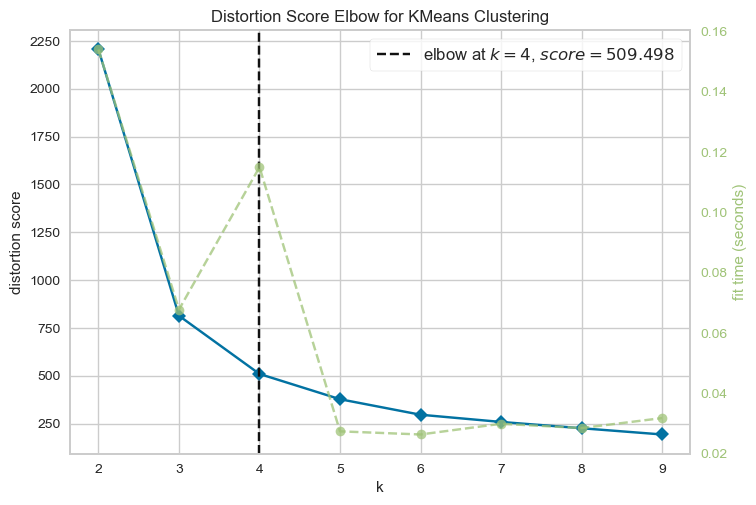

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

plt.rc('axes', labelweight='normal')
visualizer = KElbowVisualizer(model, k=(2,10), timings=True)
visualizer.fit(reduced_data)
visualizer.show()

Clustering of dimensionality reduced data using kmeans

In [6]:
kmeans = KMeans(n_clusters=4, random_state=42)  # Specify the number of clusters
clusters = kmeans.fit(reduced_data)
# clusters.labels_

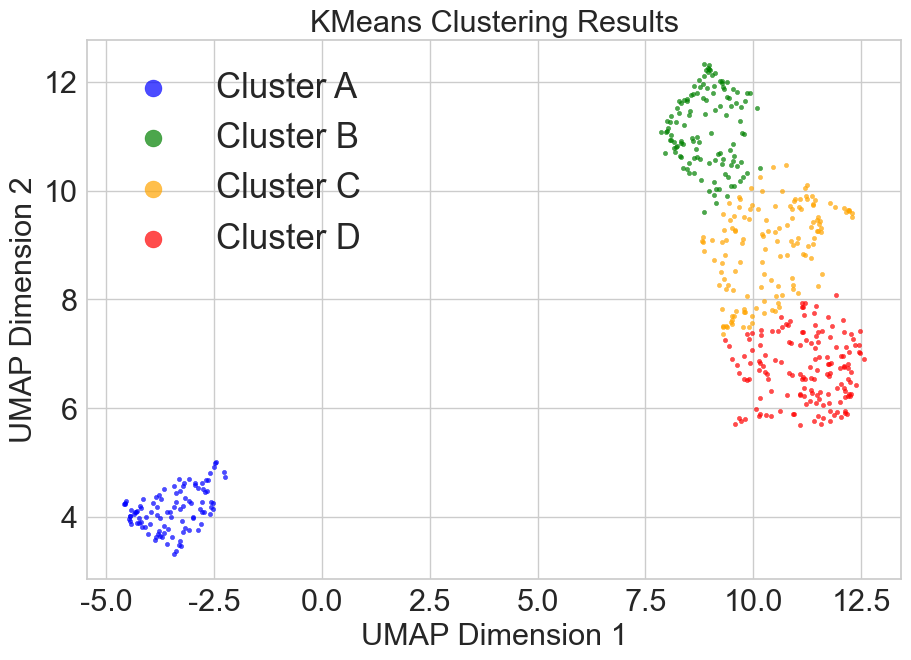

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming reduced_data is UMAP-embedded data and clusters.labels_ contains cluster assignments

# Create a figure for the scatter plot
plt.figure(figsize=(10.5, 7))

# Get unique cluster labels
unique_labels = np.unique(clusters.labels_)

# Define a mapping of cluster labels
category_colors = {
    "Cluster A": "blue",
    "Cluster B": "green",
    "Cluster C": "orange",
    "Cluster D": "red"
}

# Initialize a list to store legend handles
legend_handles = []
categories = ['Cluster A', 'Cluster B', 'Cluster C', 'Cluster D']

# Loop through different clusters and assign a unique color and label to each
for label in unique_labels:
    cluster_points = reduced_data[clusters.labels_ == label]

    # Get the corresponding category label
    category_label = categories[label]

    # Get the color for the category label from the mapping
    color = category_colors.get(category_label, 'gray')  # Default to gray if not found

    # Plot the cluster points with the assigned color and label
    scatter = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, alpha=0.7, label=f'{category_label}', color=color)

    # Append the scatter object to the legend handles
    legend_handles.append(scatter)

# Set font weight for x and y axis labels
plt.rc('axes', labelweight='bold')

# Add title and axis labels
plt.title('KMeans Clustering Results', fontsize=22)
plt.xlabel('UMAP Dimension 1', fontsize=22)
plt.ylabel('UMAP Dimension 2', fontsize=22)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Add legend with increased marker size
legend = plt.legend(handles=legend_handles, loc='upper left', fontsize=25, frameon=False)
for legend_handle in legend.legendHandles:
    legend_handle.set_sizes([150])  # Adjust the size as needed

# Save the plot as a PDF file
plt.savefig("/Users/zhangchenyang/Desktop/new_3_KMeans.pdf", format="pdf")

# Show the plot
plt.show()

Splicing the results after gene clustering with the original data

In [8]:
cluster_data = scaled_limma.copy()
cluster_data['label'] = clusters.labels_
cluster_data

,S12835,S12960,S13060,S12820,S12834,S12888,S12287,S12837,S12879,S12880,...,S12299,S12984,S12832,S13057,S12300,S12290,S12302,S12303,S12304,label
X10004,-0.953914,0.496220,-0.093465,-0.321337,0.095528,-0.169260,0.780446,0.070355,0.319812,0.392665,...,0.752721,0.283206,0.468953,-0.392719,1.097196,0.439317,-0.118468,0.505243,-0.485481,3
X10006,-0.677803,0.749330,-0.145793,-0.401175,-0.226143,1.680268,0.106641,0.083006,-0.233384,0.092001,...,0.621312,1.256759,0.852110,0.178111,-0.979156,1.444822,-0.000274,-0.747276,0.219823,1
X10029,0.134363,0.173628,-0.903233,-0.874972,0.584569,0.079528,-0.838370,-0.347121,-0.271691,0.051908,...,1.035231,-1.349398,1.019254,1.253048,0.162569,1.017342,-0.059699,0.867792,0.621563,2
X10110,-1.232119,-1.537189,-0.938923,-1.115099,-0.801743,-1.468545,-0.476228,-0.810124,-0.696413,-0.716975,...,-0.887868,1.828463,-0.413933,-0.904416,-0.051330,-0.432538,-0.725909,-0.168353,-0.401081,1
X10136,1.156478,2.008601,1.206699,1.467266,1.321242,1.844560,0.448920,0.878186,0.271784,0.532885,...,-2.060304,-2.022716,-1.855941,-1.438102,-2.052736,-2.085331,-2.009104,-1.966439,-2.343644,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X9893,-1.207807,-1.664518,-1.149274,-1.701309,-1.530714,-1.754285,-1.666872,-1.447282,-1.757011,-1.720962,...,1.066142,2.324954,0.351445,-0.255822,0.564402,-0.081997,0.396257,-0.119726,1.277808,2
X993,-1.018882,-0.986750,-0.730442,-0.779562,-0.114243,-1.100439,-0.612683,0.810276,-0.534871,-0.732063,...,0.818744,0.546051,-0.219683,0.244745,0.780714,-0.074717,-0.129542,0.303180,1.069927,1
X9965,-1.231052,0.704675,-0.909309,-0.969908,-1.339852,0.182732,-1.497575,-0.755854,-1.115877,-0.724149,...,1.492453,2.110155,0.557039,0.261450,0.369871,0.387316,0.615593,0.619226,0.373043,2
X9968,1.294620,1.921230,0.937381,-0.106472,1.164330,0.227750,0.094691,-0.885411,0.784437,-0.348691,...,0.735719,0.259814,0.572397,1.039805,0.323347,1.418748,1.399023,-0.579767,0.874452,3


The number of Genes

In [9]:
from collections import Counter

element_counts = Counter(cluster_data['label'])

# 打印结果
for element, count in element_counts.items():
    print(f"{element}: {count} times")

3: 154 次
1: 122 次
2: 139 次
0: 100 次


Plotting the number of genes on a bar graph

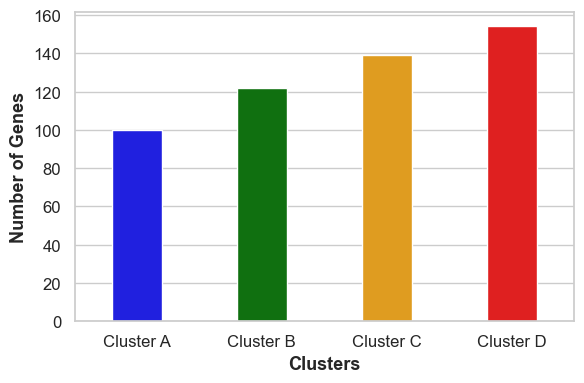

In [264]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a list of categories and corresponding colors
category_colors = {
    "Cluster A": "blue",
    "Cluster B": "green",
    "Cluster C": "orange",
    "Cluster D": "red"
}

# Assuming you have a list of categories and corresponding values
categories = ["Cluster A", "Cluster B", "Cluster C", "Cluster D"]
values = [100, 122, 139, 154]

# Create Seaborn style bar plot
sns.set(style="whitegrid")

# Specify the bar width
bar_width = 0.4

# Create the bar plot and set the palette based on category_colors
plt.figure(figsize=(6, 4))
sns.barplot(x=categories, y=values, palette=[category_colors[cat] for cat in categories], ci=None, capsize=0.2, width=bar_width)

# Set the font weight for the x and y axis labels
plt.rc('axes', labelweight='bold')

# Set the labels for x and y axes
plt.xlabel("Clusters", fontsize=13)
plt.ylabel("Number of Genes",  fontsize=13)

plt.xticks(fontsize=12)
# , rotation=15
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig("/Users/zhangchenyang/Desktop/new_3_numbers.pdf", format="pdf")

# Show the plot
plt.show()

Extraction of the first principal component for each type of gene

In [10]:
from sklearn.decomposition import PCA

cluster_class_data  = pd.DataFrame()
for m in range(4):
    class_m = cluster_data[cluster_data['label'] == m]
    class_m = class_m.iloc[:,:-1].T
    # first principal component
    pca = PCA(n_components=1)
    cluster_class_data = pd.concat([cluster_class_data, pd.DataFrame(pca.fit_transform(class_m)[:,0])], axis=1)


cluster_class_data.columns = ["ClusterA", "ClusterB", "ClusterC", "ClusterD"]

cluster_class_data['fenzu_list'] = cluster_data.columns[:-1]
cluster_class_data= pd.merge(cluster_class_data, group, left_on='fenzu_list',right_on='donor_id')

cluster_class_data.drop(['fenzu_list','donor_id'], axis=1, inplace=True)
cluster_class_data

,ClusterA,ClusterB,ClusterC,ClusterD,stage
0,14.459632,-4.733360,6.670026,-1.998562,age0
1,13.646047,-5.021208,7.653385,-2.252668,age0
2,15.242843,-3.827106,9.651940,-2.029044,age0
3,13.765058,-4.110280,9.361945,-3.758565,age0
4,15.934637,-4.099078,7.873178,-1.066221,age0
5,14.539088,-4.653281,8.612796,-1.949549,age0
6,14.818769,-3.995231,9.980737,-0.424809,age0
7,15.028265,-3.407207,9.604763,-2.433834,age0
8,12.725609,-2.740619,10.142026,-1.941922,age0
9,14.976739,-3.151031,10.922260,-1.075187,age0


Calculate the variance contribution of the first principal component

In [11]:
for m in range(4):
    class_m = cluster_data[cluster_data['label'] == m]
    class_m = class_m.iloc[:,:-1].T
    # first principal component
    pca = PCA()
    pca.fit_transform(class_m)
    first_principal_component_variance = pca.explained_variance_[0]  # Variance of the first principal component
    total_variance = np.sum(pca.explained_variance_)  # total variance
    contribution_ratio = first_principal_component_variance / total_variance
    print(contribution_ratio)

0.7400718726954773
0.3413049259284413
0.4558431526690638
0.18759804954098427


Plotting the bar chart of the variance contribution of the first principal component

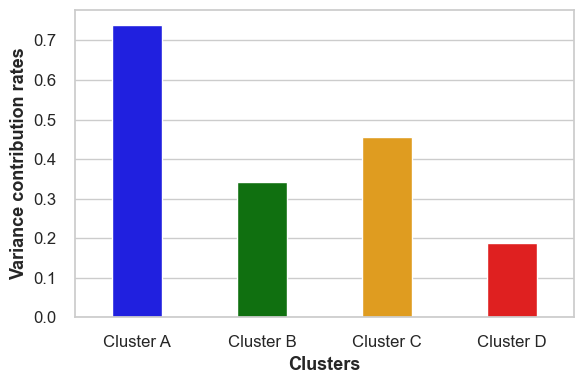

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a list of categories and corresponding colors
category_colors = {
    "Cluster A": "blue",
    "Cluster B": "green",
    "Cluster C": "orange",
    "Cluster D": "red"
}

# Assuming you have a list of categories and corresponding values
categories = ["Cluster A", "Cluster B", "Cluster C", "Cluster D"]
values = [0.7400718726954773, 0.3413049259284413, 0.4558431526690638, 0.18759804954098427]

# Create Seaborn style bar plot
sns.set(style="whitegrid")

# Specify the bar width
bar_width = 0.4

# Create the bar plot and set the palette based on category_colors
plt.figure(figsize=(6, 4))
sns.barplot(x=categories, y=values, palette=[category_colors[cat] for cat in categories], ci=None, capsize=0.2, width=bar_width)

# Set the font weight for the x and y axis labels
plt.rc('axes', labelweight='bold')

# Set the labels for x and y axes
plt.xlabel("Clusters", fontsize=13)
plt.ylabel("Variance contribution rates", fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig("/Users/zhangchenyang/Desktop/new_3_contribution.pdf", format="pdf")

# Show the plot
plt.show()

Decision Tree Validation

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
import graphviz

from sklearn.utils import shuffle
cluster_class_data = shuffle(cluster_class_data, random_state=42)

Disrupt the order of the samples 20 times and calculate the average accuracy

In [15]:
e_m_l = []
e_m = []
e_l = []
m_l = []

for i in range(20):
    cluster_class_data = shuffle(cluster_class_data, random_state=i)

    # early, middle and late stage
    data1 = cluster_class_data.copy()
    CART_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=2)
    temp1 = cross_val_score(CART_tree, data1.drop('stage', axis=1),
                            data1['stage'], cv=6,n_jobs=-1).mean()
    e_m_l.append(temp1)

    # early and middle stage
    data2 = cluster_class_data[cluster_class_data['stage'] != 'age2']
    CART_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    temp2 = cross_val_score(CART_tree, data2.drop('stage', axis=1),
                            data2['stage'], cv=6,n_jobs=-1).mean()
    e_m.append(temp2)

    # early and late stage
    data3 = cluster_class_data[cluster_class_data['stage'] != 'age1']
    CART_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    temp3 = cross_val_score(CART_tree, data3.drop('stage', axis=1),
                            data3['stage'], cv=6,n_jobs=-1).mean()
    e_l.append(temp3)

    # middle and late stage
    data4 = cluster_class_data[cluster_class_data['stage'] != 'age0']
    CART_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    temp4 = cross_val_score(CART_tree, data4.drop('stage', axis=1),
                            data4['stage'], cv=6,n_jobs=-1).mean()
    m_l.append(temp4)

print('early, middle and late stage：', np.mean(e_m_l))
print('early and middle stage：', np.mean(e_m))
print('early and late stage：', np.mean(e_l))
print('middle and late stage：', np.mean(m_l))

e_m_l： 0.8924603174603174
e_m： 0.9116666666666665
e_l： 0.9444444444444443
m_l： 0.9506944444444443


Disrupt the sample order 20 times and calculate the average feature importance

In [16]:
# View the classification features used for each cross-validation
from sklearn.model_selection import KFold

feature_importances_1 = []
feature_importances_2 = []
feature_importances_3 = []
feature_importances_4 = []

for i in range(20):
    cluster_class_data = shuffle(cluster_class_data, random_state=i)

    # early, middle and late stage---------------------------------------------------------------------------------
    data1 = cluster_class_data.copy()

    X = data1.drop('stage', axis=1)
    y = data1['stage']
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=2)
    cv = KFold(n_splits=6,)

    for train_index, test_index in cv.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)

        importance = clf.feature_importances_
        feature_importances_1.append(list(importance))


    # early and middle stage---------------------------------------------------------------------------------
    data2 = cluster_class_data[cluster_class_data['stage'] != 'age2']

    X = data2.drop('stage', axis=1)
    y = data2['stage']
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    cv = KFold(n_splits=6,)

    for train_index, test_index in cv.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)

        importance = clf.feature_importances_
        feature_importances_2.append(list(importance))


    # early and late stage---------------------------------------------------------------------------------
    data3 = cluster_class_data[cluster_class_data['stage'] != 'age1']

    X = data3.drop('stage', axis=1)
    y = data3['stage']
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    cv = KFold(n_splits=6,)

    for train_index, test_index in cv.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)

        importance = clf.feature_importances_
        feature_importances_3.append(list(importance))


    # middle and late stage---------------------------------------------------------------------------------
    data4 = cluster_class_data[cluster_class_data['stage'] != 'age0']

    X = data4.drop('stage', axis=1)
    y = data4['stage']
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    cv = KFold(n_splits=6,)

    for train_index, test_index in cv.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)

        importance = clf.feature_importances_
        feature_importances_4.append(list(importance))



# early, middle and late stage---------------------------------------------------------------------------------
sums = [0] * len(feature_importances_1[0])
for sublist in feature_importances_1:
    for i, value in enumerate(sublist):
        sums[i] += value
num_sublists = len(feature_importances_1)
averages = [total / num_sublists for total in sums]
print("early, middle and late stage：", averages)


# early and middle stage---------------------------------------------------------------------------------
sums = [0] * len(feature_importances_2[0])
for sublist in feature_importances_2:
    for i, value in enumerate(sublist):
        sums[i] += value
num_sublists = len(feature_importances_2)
averages = [total / num_sublists for total in sums]
print("early and middle stage：", averages)


# early and late stage---------------------------------------------------------------------------------
sums = [0] * len(feature_importances_3[0])
for sublist in feature_importances_3:
    for i, value in enumerate(sublist):
        sums[i] += value
num_sublists = len(feature_importances_3)
averages = [total / num_sublists for total in sums]
print("early and late stage：", averages)


# middle and late stage---------------------------------------------------------------------------------
sums = [0] * len(feature_importances_4[0])
for sublist in feature_importances_4:
    for i, value in enumerate(sublist):
        sums[i] += value
num_sublists = len(feature_importances_4)
averages = [total / num_sublists for total in sums]
print("middle and late stage：", averages)

### Early, middle and late decision trees

In [18]:
dt_data_ = cluster_class_data.copy()

feature=dt_data_.columns.to_list()[:-1]
class_names = dt_data_['stage'].unique()
class_names

array(['age0', 'age2', 'age1'], dtype=object)

In [336]:
CART_tree = DecisionTreeClassifier(
    criterion='gini', splitter='best', max_depth=2)

e_m_l = cross_val_score(CART_tree, dt_data_.drop('stage', axis=1),
                        dt_data_['stage'], cv=6,n_jobs=-1).mean()

e_m_l

0.9206349206349206

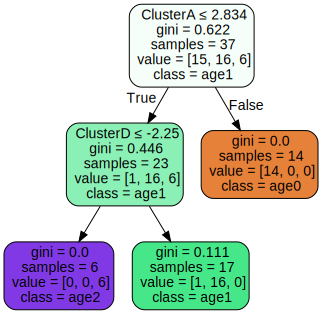

In [276]:
CART_tree = DecisionTreeClassifier(criterion='gini',splitter = 'best',max_depth=2)
CART_tree.fit(dt_data_.drop('stage', axis=1), dt_data_['stage'])
dot_data = tree.export_graphviz(CART_tree,
                                feature_names=feature,
                                class_names=[str(k) for k in np.unique(dt_data_['stage'])],
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

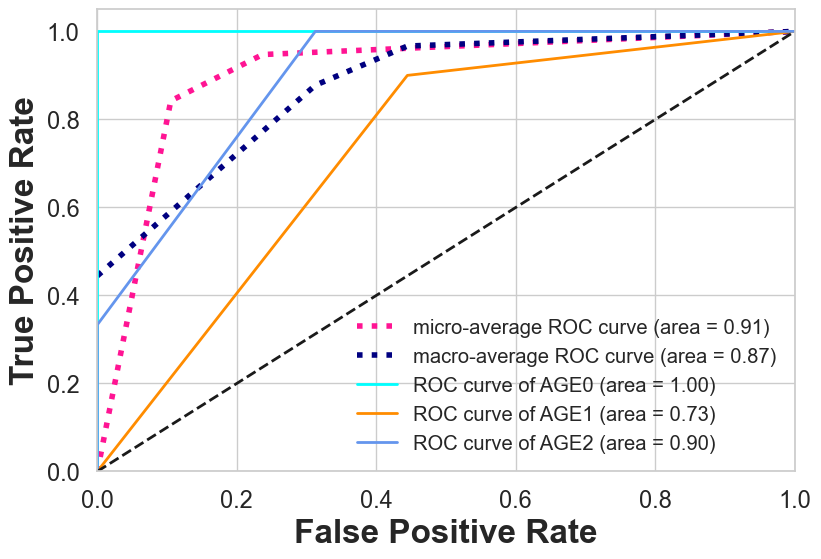

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

X = cluster_class_data.iloc[:, :4]
y = cluster_class_data.iloc[:, -1]

y = y.replace({'age0': 0, 'age1': 1, 'age2': 2})

y_binarized = label_binarize(y, classes=[0, 1, 2])
n_classes = y_binarized.shape[1]

random_state = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=.5, random_state=random_state)

tree_classifier = DecisionTreeClassifier(random_state=random_state, max_depth=2)

# build OneVsRestClassifier
classifier = OneVsRestClassifier(tree_classifier)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# calculate ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure(figsize=(9, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of AGE{0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", fontsize = 14.5, frameon=False)

plt.savefig("/Desktop/new_3_e_m_l_ROC.pdf", format="pdf", bbox_inches = 'tight')
plt.show()

### Early and mid-term decision trees

In [19]:
dt_data_ = cluster_class_data[cluster_class_data['stage'] != 'age2']

feature=dt_data_.columns.to_list()[:-1]
class_names = dt_data_['stage'].unique()
class_names

array(['age0', 'age1'], dtype=object)

In [279]:
CART_tree = DecisionTreeClassifier(
    criterion='gini', splitter='best', max_depth=1)

e_m = cross_val_score(CART_tree, dt_data_.drop('stage', axis=1),
                      dt_data_['stage'], cv=6,n_jobs=-1).mean()
e_m

0.9333333333333332

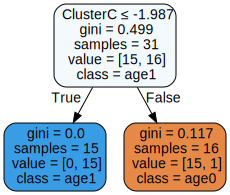

In [281]:
CART_tree = DecisionTreeClassifier(criterion='gini',splitter = 'best',max_depth=1)
CART_tree.fit(dt_data_.drop('stage', axis=1), dt_data_['stage'])
dot_data = tree.export_graphviz(CART_tree,
                                feature_names=feature,
                                class_names=[str(k) for k in np.unique(dt_data_['stage'])],
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

<Figure size 800x550 with 0 Axes>

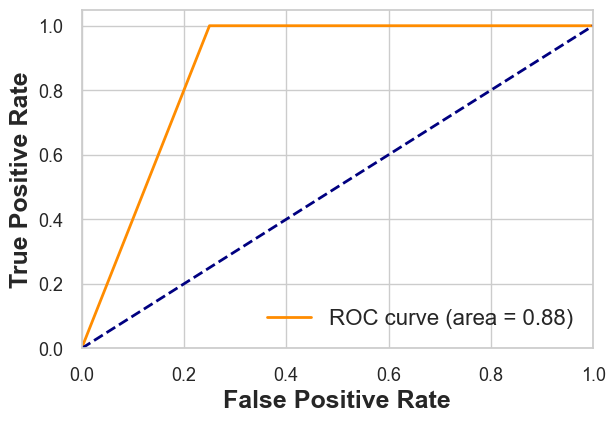

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

dt_data_ = cluster_class_data[cluster_class_data['stage'] != 'age2']

X = dt_data_.iloc[:, :4]
y = dt_data_.iloc[:, -1]

y = y.replace({'age0': 0, 'age1': 1})

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score, drop_intermediate=True)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.figure(figsize=(6.6, 4.4))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.legend(loc="lower right", frameon=False, fontsize = 16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig("/Desktop/new_3_e_m_ROC.pdf", format="pdf", bbox_inches = 'tight')

plt.show()

### Early and Late Decision Trees

In [32]:
dt_data_ = cluster_class_data[cluster_class_data['stage'] != 'age1']

feature=dt_data_.columns.to_list()[:-1]
class_names = dt_data_['stage'].unique()
class_names

array(['age0', 'age2'], dtype=object)

In [285]:
CART_tree = DecisionTreeClassifier(
    criterion='gini', splitter='best', max_depth=1)

e_l = cross_val_score(CART_tree, dt_data_.drop('stage', axis=1),
                      dt_data_['stage'], cv=6,n_jobs=-1).mean()
e_l

0.9444444444444445

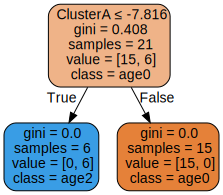

In [287]:
CART_tree = DecisionTreeClassifier(criterion='gini',splitter = 'best',max_depth=1)
CART_tree.fit(dt_data_.drop('stage', axis=1), dt_data_['stage'])
dot_data = tree.export_graphviz(CART_tree,
                                feature_names=feature,
                                class_names=[str(k) for k in np.unique(dt_data_['stage'])],
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

<Figure size 800x550 with 0 Axes>

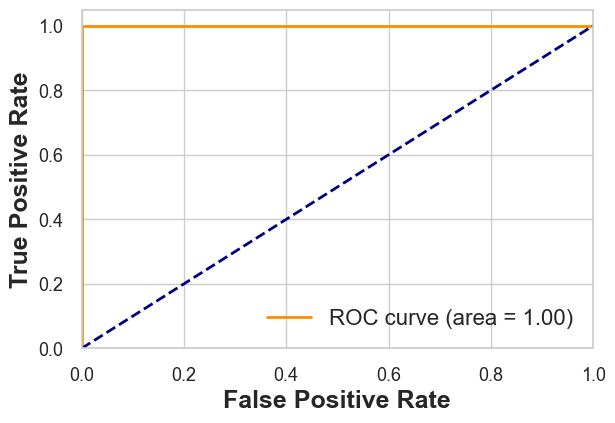

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

dt_data_ = cluster_class_data[cluster_class_data['stage'] != 'age1']

X = dt_data_.iloc[:, :4]
y = dt_data_.iloc[:, -1]

y = y.replace({'age0': 0, 'age2': 1})

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.figure(figsize=(6.6, 4.4))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.legend(loc="lower right", frameon=False, fontsize = 16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig("/Desktop/new_3_e_l_ROC.pdf", format="pdf", bbox_inches = 'tight')

plt.show()

### Middle and Late Decision Trees

In [34]:
dt_data_ = cluster_class_data[cluster_class_data['stage'] != 'age0']

feature=dt_data_.columns.to_list()[:-1]
class_names = dt_data_['stage'].unique()
class_names

array(['age2', 'age1'], dtype=object)

In [35]:
CART_tree = DecisionTreeClassifier(
    criterion='gini', splitter='best', max_depth=1)

m_l = cross_val_score(CART_tree, dt_data_.drop('stage', axis=1),
                      dt_data_['stage'], cv=6,n_jobs=-1).mean()
m_l

0.9583333333333334

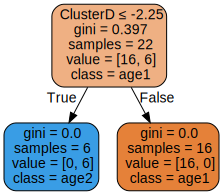

In [293]:
CART_tree = DecisionTreeClassifier(criterion='gini',splitter = 'best',max_depth=1)
CART_tree.fit(dt_data_.drop('stage', axis=1), dt_data_['stage'])
dot_data = tree.export_graphviz(CART_tree,
                                feature_names=feature,
                                class_names=[str(k) for k in np.unique(dt_data_['stage'])],
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

<Figure size 800x550 with 0 Axes>

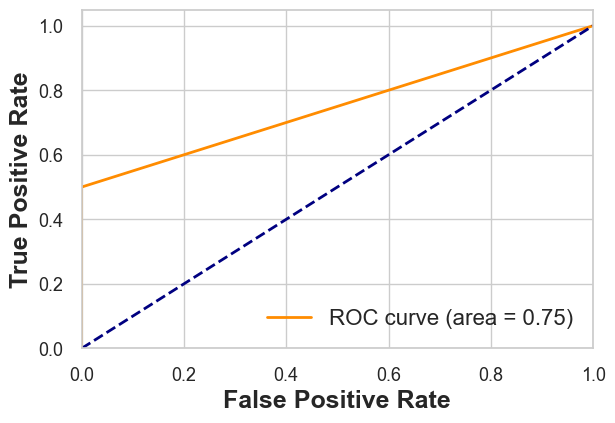

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

dt_data_ = cluster_class_data[cluster_class_data['stage'] != 'age0']

X = dt_data_.iloc[:, :4]
y = dt_data_.iloc[:, -1]

y = y.replace({'age1': 0, 'age2': 1})

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.figure(figsize=(6.6, 4.4))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.legend(loc="lower right", frameon=False, fontsize = 16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig("/Desktop/new_3_m_l_ROC.pdf", format="pdf", bbox_inches = 'tight')

plt.show()

In [296]:
print('e_m_l：', e_m_l)
print('e_m：', e_m)
print('e_l：', e_l)
print('m_l：', m_l)

e_m_l： 0.8928571428571428
e_m： 0.9333333333333332
e_l： 0.9444444444444445
m_l： 0.9583333333333334
